# WORLD CUP QATAR-2022 FORECASTING USING MACHINE LEARNING

## 1. Import libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pycountry_convert as pc
import seaborn as sns
from sklearn.model_selection import train_test_split 

## 2. Exploring some datesets to determine which would be better for the model

In [6]:
wcup = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Assorted-Projects\Datasets\WorldCUP\WorldCupMatches.csv')

In [7]:
wcup.head()

,Year,Datetime,Stage,Stadium,City,Home Team Name,Home Team Goals,Away Team Goals,Away Team Name,Win conditions,Attendance,Half-time Home Goals,Half-time Away Goals,Referee,Assistant 1,Assistant 2,RoundID,MatchID,Home Team Initials,Away Team Initials
0,1930.0,13 Jul 1930 - 15:00,Group 1,Pocitos,Montevideo,France,4.0,1.0,Mexico,,4444.0,3.0,0.0,LOMBARDI Domingo (URU),CRISTOPHE Henry (BEL),REGO Gilberto (BRA),201.0,1096.0,FRA,MEX
1,1930.0,13 Jul 1930 - 15:00,Group 4,Parque Central,Montevideo,USA,3.0,0.0,Belgium,,18346.0,2.0,0.0,MACIAS Jose (ARG),MATEUCCI Francisco (URU),WARNKEN Alberto (CHI),201.0,1090.0,USA,BEL
2,1930.0,14 Jul 1930 - 12:45,Group 2,Parque Central,Montevideo,Yugoslavia,2.0,1.0,Brazil,,24059.0,2.0,0.0,TEJADA Anibal (URU),VALLARINO Ricardo (URU),BALWAY Thomas (FRA),201.0,1093.0,YUG,BRA
3,1930.0,14 Jul 1930 - 14:50,Group 3,Pocitos,Montevideo,Romania,3.0,1.0,Peru,,2549.0,1.0,0.0,WARNKEN Alberto (CHI),LANGENUS Jean (BEL),MATEUCCI Francisco (URU),201.0,1098.0,ROU,PER
4,1930.0,15 Jul 1930 - 16:00,Group 1,Parque Central,Montevideo,Argentina,1.0,0.0,France,,23409.0,0.0,0.0,REGO Gilberto (BRA),SAUCEDO Ulises (BOL),RADULESCU Constantin (ROU),201.0,1085.0,ARG,FRA


In [8]:
wcup.head(3)

,Year,Datetime,Stage,Stadium,City,Home Team Name,Home Team Goals,Away Team Goals,Away Team Name,Win conditions,Attendance,Half-time Home Goals,Half-time Away Goals,Referee,Assistant 1,Assistant 2,RoundID,MatchID,Home Team Initials,Away Team Initials
0,1930.0,13 Jul 1930 - 15:00,Group 1,Pocitos,Montevideo,France,4.0,1.0,Mexico,,4444.0,3.0,0.0,LOMBARDI Domingo (URU),CRISTOPHE Henry (BEL),REGO Gilberto (BRA),201.0,1096.0,FRA,MEX
1,1930.0,13 Jul 1930 - 15:00,Group 4,Parque Central,Montevideo,USA,3.0,0.0,Belgium,,18346.0,2.0,0.0,MACIAS Jose (ARG),MATEUCCI Francisco (URU),WARNKEN Alberto (CHI),201.0,1090.0,USA,BEL
2,1930.0,14 Jul 1930 - 12:45,Group 2,Parque Central,Montevideo,Yugoslavia,2.0,1.0,Brazil,,24059.0,2.0,0.0,TEJADA Anibal (URU),VALLARINO Ricardo (URU),BALWAY Thomas (FRA),201.0,1093.0,YUG,BRA


In [9]:
oppo_list = glob.glob(r'C:\Users\USUARIO\Documents\GitHub\Assorted-Projects\Datasets\WorldCUP\archive\International_Football_History_Countries\*\Opponents_History.csv')

In [10]:
opponent_history = pd.DataFrame()

for i,path in enumerate(oppo_list):
    team = pd.read_csv(path)
    team['Main'] = oppo_list[i].split('\\')[10]
    opponent_history = pd.concat([opponent_history, team], axis=0)

In [11]:
opp_history = opponent_history[opponent_history.Squad != 'Squad']

In [12]:
opp_history.head()

,Squad,MP,W,D,L,GF,GA,GD,PPM,Head-to-Head,Main
0,cl Chile,19,11,7,1,30,13,+17,2.05,Head-to-Head,Argentina
1,uy Uruguay,17,11,3,3,27,15,+12,2.06,Head-to-Head,Argentina
2,br Brazil,17,5,4,8,15,26,-11,1.06,Head-to-Head,Argentina
3,bo Bolivia,16,11,3,2,41,16,+25,2.25,Head-to-Head,Argentina
4,co Colombia,16,8,6,2,20,10,+10,1.88,Head-to-Head,Argentina


In [13]:
ecu_wc = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Assorted-Projects\Datasets\WorldCUP\archive\International_Football_History_Countries\Ecuador\Worldcups_History.csv')
ecu_wc.head()

,Season,Squad,Comp,LgRank,MP,W,D,L,GF,GA,GD,Pts,Top Team Scorer,Goalkeeper,Notes
0,2022,Ecuador,1. FIFA World Cup,GR,0,0,0,0,0,0,0,0,NaN,NaN,NaN
1,2014,Ecuador,1. FIFA World Cup,GR,3,1,1,1,3,3,0,4,Enner Valencia - 3,Alexander Domínguez,NaN
2,2006,Ecuador,1. FIFA World Cup,R16,4,2,0,2,5,4,1,6,"Agustín Delgado, Carlos Tenorio - 2",Cristian Mora,NaN
3,2002,Ecuador,1. FIFA World Cup,GR,3,1,0,2,2,4,-2,3,"Agustín Delgado, Édison Méndez - 1",José Francisco Cevallos,NaN


### Dataset results could be better to predict matches head-head given the amount of data available

In [14]:
all_results = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Assorted-Projects\Datasets\WorldCUP\results.csv')
all_results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False


In [15]:
all_results.dropna(inplace=True)

In [16]:
all_results['date'] = pd.to_datetime(all_results.date, infer_datetime_format=True)

### One external feature which could help forecasting is the Ranking FIFA

In [17]:
ranking_fifa = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Assorted-Projects\Datasets\WorldCUP\fifa_ranking-2022-10-06.csv')

In [18]:
ranking_fifa['rank_date'] = pd.to_datetime(ranking_fifa.rank_date, infer_datetime_format=True)

In [19]:
ranking_fifa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63916 entries, 0 to 63915
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   rank             63916 non-null  int64         
 1   country_full     63916 non-null  object        
 2   country_abrv     63916 non-null  object        
 3   total_points     63916 non-null  float64       
 4   previous_points  63916 non-null  float64       
 5   rank_change      63916 non-null  int64         
 6   confederation    63916 non-null  object        
 7   rank_date        63916 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 3.9+ MB


In [20]:
ranking_fifa['Year'] = pd.DatetimeIndex(ranking_fifa.rank_date).year

#### -  Since the competition does not match when FIFA Ranking is published, the average year will be taken into account

In [21]:
rank_avg_year = ranking_fifa.groupby(['Year', 'country_full']).mean()

In [22]:
rank_avg_year.reset_index(inplace=True)

In [23]:
rank_avg_year[rank_avg_year.country_full == 'Ecuador'].head()

,Year,country_full,rank,total_points,previous_points,rank_change
37,1992,Ecuador,65.0,23.0,0.0,0.0
186,1993,Ecuador,42.4,37.0,34.6,-3.4
343,1994,Ecuador,49.3,33.5,33.8,0.7
514,1995,Ecuador,60.5,32.6,32.1,0.0
692,1996,Ecuador,38.4,43.8,42.8,-2.2


In [24]:
all_results.date = pd.to_datetime(all_results.date, infer_datetime_format=True)

In [25]:
all_results['Year'] = pd.DatetimeIndex(all_results.date).year

In [26]:
all_results[all_results.home_team == 'Ecuador']

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,Year
2141,1938-08-11,Ecuador,Peru,1.0,9.0,Bolivarian Games,Bogotá,Colombia,True,1938
2148,1938-08-19,Ecuador,Venezuela,5.0,2.0,Bolivarian Games,Bogotá,Colombia,True,1938
2193,1939-01-22,Ecuador,Uruguay,0.0,6.0,Copa América,Lima,Peru,True,1939
2201,1939-02-12,Ecuador,Paraguay,1.0,3.0,Copa América,Lima,Peru,True,1939
2340,1941-02-09,Ecuador,Uruguay,0.0,6.0,Copa América,Santiago,Chile,True,1941
...,...,...,...,...,...,...,...,...,...,...
43391,2022-01-27,Ecuador,Brazil,1.0,1.0,FIFA World Cup qualification,Quito,Ecuador,False,2022
43556,2022-03-29,Ecuador,Argentina,1.0,1.0,FIFA World Cup qualification,Guayaquil,Ecuador,False,2022
43660,2022-06-02,Ecuador,Nigeria,1.0,0.0,Friendly,Harrison,United States,True,2022
43850,2022-06-11,Ecuador,Cape Verde,1.0,0.0,Friendly,Fort Lauderdale,United States,True,2022


#### - Merging both Datasets Ranking_fifa and All_Results

In [27]:
results_rank = pd.merge(all_results, rank_avg_year, how='left', left_on=['home_team','Year'], right_on=['country_full','Year'])

In [28]:
# Drop columns that are not useful anymore 
results_rank.drop(columns=['city', 'Year','country_full', 'previous_points','rank_change'], axis=1, inplace=True)

In [29]:
results_rank.sort_values(by=['home_team','date'], inplace=True)

In [30]:
result_rank = results_rank.reset_index(drop=True)

In [31]:
# Populate NA values
results_rank.fillna(method='bfill', inplace=True)

In [32]:
# Drop NA values
results_rank.dropna(inplace=True)

In [33]:
results_rank.reset_index(drop=True, inplace=True)

In [34]:
results_rank[['rank','total_points']] = results_rank[['rank','total_points']].astype(int)

In [35]:
# Code the result as 3 = home_team wins, 1 = tie, 0 = home_team loses
result = []
for row in range(len(results_rank)):
    if results_rank.home_score[row] == results_rank.away_score[row]:
        result.append(1)
    
    elif results_rank.home_score[row] > results_rank.away_score[row]:
        result.append(3)

    else: 
        result.append(0)

In [36]:

results_rank['result'] = result

In [37]:
# Replace unknown-code country
results_rank.country.replace({'England':'United Kingdom','Wales':'United Kingdom', 'Western Samoa':'Samoa', 'China PR':'China'
,'Netherlands Guyana':'Guyana', 'Netherlands Antilles':'Haiti', 'Antilles':'Haiti','Vietnam Republic':'Vietnam', 'Soviet Union':'Russia',
'British Guyana':'Guyana','Dahomey':'Suriname','Surinam':'Suriname','Upper Volta':'Nigeria', 'Yugoslavia':'Czech Republic','Malaya':'Malaysia',
'Sint Maarten':'Haiti','Manchuria':'China','Burma':'Myanmar', 'Vietnam DR':'Vietnam', 'Zaïre':'Congo', 'Scotland':'United Kingdom',
'Bohemia':'Czech Republic', 'Czechoslovakia':'Czech Republic','Bohemia and Moravia':'Czech Republic','Belgian Congo':'Congo','DR Congo':'Congo'
,'French Somaliland':'Congo', 'United Arab Republic':'Egypt', 'Lautoka':'Fiji','German DR':'Germany','Gold Coast':'Australia',
'Northern Rhodesia':'Egypt', 'Portuguese Guinea':'Guinea', 'Ceylon':'Sri Lanka','Tanganyika':'Tanzania', 'Zanzibar':'Tanzania',
'Kosovo':'Russia','Nyasaland':'Malawi', 'Mali Federation':'Mali','Northern Ireland':'Ireland','Irish Free State':'Ireland','Éire':'Ireland', 
'Republic of Ireland':'Ireland', 'Saarland':'Germany', 'Serbia and Montenegro':'Serbia','Tahiti':'New Zealand','East Timor':'Indonesia',
'New Hebrides':'New Zealand','Yemen AR':'Yemen','Yemen DPR':'Yemen', 'Southern Rhodesia':'Congo','Rhodesia':'Congo'}, inplace=True)

#### - Mapping continents where the games took place

In [38]:
continent_dict = {}

for country in results_rank.country.unique():
    country_code = pc.country_name_to_country_alpha2(country, cn_name_format='default')
    conti_code = pc.country_alpha2_to_continent_code(country_code)
    continent_dict[country] = conti_code

In [39]:
results_rank['continent'] = results_rank.country.map(continent_dict)

In [40]:
all_games_results = results_rank.copy()

In [41]:
all_games_results.drop(columns=['home_score', 'away_score','country'], axis=1, inplace=True)

In [42]:
all_games_results[all_games_results.away_team == 'Ecuador']

,date,home_team,away_team,tournament,neutral,rank,total_points,result,continent
1139,1941-02-16,Argentina,Ecuador,Copa América,True,10,51,3,SA
1143,1942-01-22,Argentina,Ecuador,Copa América,True,10,51,3,SA
1151,1945-01-31,Argentina,Ecuador,Copa América,True,10,51,3,SA
1173,1955-03-09,Argentina,Ecuador,Copa América,True,10,51,3,SA
1189,1957-03-17,Argentina,Ecuador,Copa América,True,10,51,3,SA
...,...,...,...,...,...,...,...,...,...
42544,2012-10-16,Venezuela,Ecuador,FIFA World Cup qualification,False,46,604,1,SA
42555,2015-11-17,Venezuela,Ecuador,FIFA World Cup qualification,False,68,497,0,SA
42564,2019-06-01,Venezuela,Ecuador,Friendly,True,27,1500,1,NA
42572,2021-06-20,Venezuela,Ecuador,Copa América,True,43,1456,1,SA


In [43]:
all_games_results.set_index([all_games_results.index,'date'], inplace=True)

#### - Differentiate FIFA World Cup Games from other Tournaments and Friendly Games 

In [44]:
tournament_dict = {'FIFA World Cup':1}

In [45]:
all_games_results['wcup_games'] = all_games_results.tournament.map(tournament_dict)

In [46]:
all_games_results.fillna(0, inplace=True)

In [47]:
all_games_results['wcup_games'] = all_games_results['wcup_games'].astype(int)

#### - Encode all object variables into numbers

In [48]:
country_dict = {}

for i, country in enumerate(sorted(list(set(pd.concat([all_games_results.home_team, all_games_results.away_team], axis=0))))):
    country_dict[country] = i

In [49]:
all_games_results['home_code'] = all_games_results.home_team.map(country_dict)
all_games_results['away_code'] = all_games_results.away_team.map(country_dict)

In [50]:
all_games_results['neutral'] = all_games_results['neutral'].astype(int)

In [51]:
all_games_results['continent'] = all_games_results['continent'].astype('category').cat.codes

In [52]:
all_games_code = all_games_results.copy()

In [53]:
# Drop categorical variables
all_games_code.drop(['home_team','away_team','tournament'], axis=1, inplace=True)

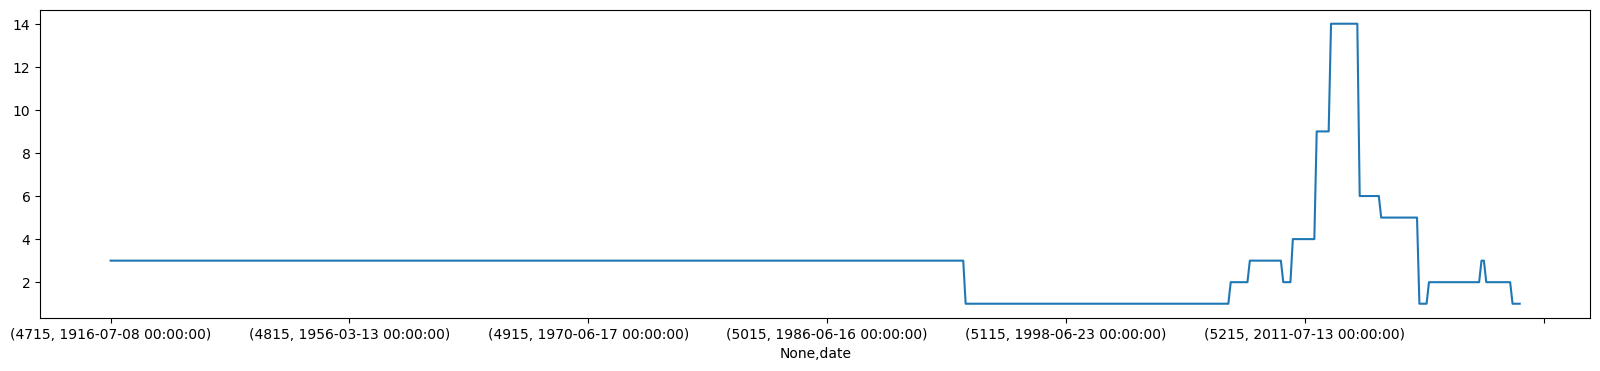

In [54]:
all_games_results[all_games_results.home_team == 'Brazil']['rank'].plot(figsize=(20,4))
plt.show()

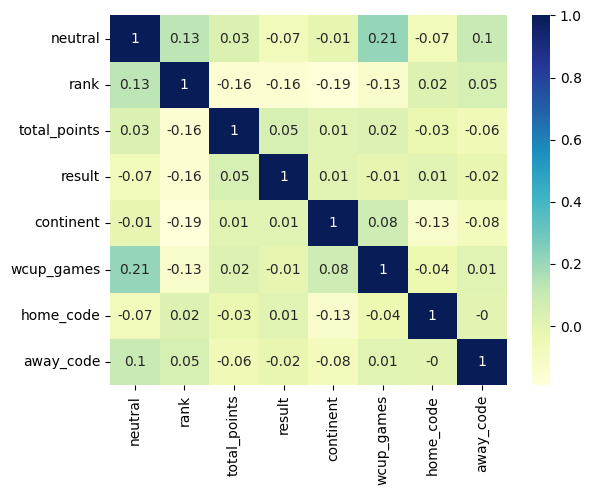

In [55]:
sns.heatmap(round(all_games_code.corr(),2), cmap="YlGnBu", annot=True);

## 4. Split dataset into training and validation sets

In [56]:
Y = all_games_code.result
X = all_games_code.drop('result', axis=1)

In [57]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.25, random_state=82)

In [58]:
X_train

,,neutral,rank,total_points,continent,wcup_games,home_code,away_code
,date,,,,,,,
15353,2010-06-02,0,31,38,2,0,108,201
15915,2017-05-17,0,199,4,3,0,112,79
12312,1998-08-02,0,144,13,0,0,89,159
4826,1957-06-16,0,3,56,5,0,38,216
34108,2021-06-05,0,57,1397,1,0,240,306
...,...,...,...,...,...,...,...,...
19805,1968-06-08,0,2,57,2,0,134,311
31131,1978-11-15,0,20,46,2,0,215,265
41091,1988-02-26,0,59,25,1,0,289,82


In [59]:
X_valid

,,neutral,rank,total_points,continent,wcup_games,home_code,away_code
,date,,,,,,,
38588,1992-09-11,1,123,5,4,0,270,17
3854,2019-03-21,0,1,1749,2,0,28,226
39425,1974-11-10,0,101,10,0,0,278,153
42675,2015-10-08,0,138,202,1,0,298,129
36737,1987-01-21,0,15,49,2,0,259,187
...,...,...,...,...,...,...,...,...
14485,1934-05-31,1,1,57,2,1,104,264
5333,2010-10-15,1,187,25,3,0,39,79
33373,2002-11-13,1,177,3,3,0,232,233
